# Ch 8 - Dimensionality Reduction

Doing PCE and extracting the first two columns

In [2]:
import numpy as np
np.random.seed(42)
X = np.random.rand(100, 4) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

array([-9.54951825e-01, -2.95229944e-01,  4.57911132e-04, -3.01012031e-02])

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

## Scikit-learn's implementation of PCA 

In [8]:
from sklearn.decomposition import PCA 
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [9]:
pca.explained_variance_ratio_

array([0.29834838, 0.27777546])

Typically want to preserve about 95% of a dataset's variance

In [10]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

NameError: name 'X_train' is not defined

There is a better way to do what we did above... scikit learn has a way to call PCA such that it returns x % of the variance

### Returning a specific percentage of the variance of a dataset

In [ ]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

## MNIST Compression
Let's use PCA to reduce the dimensionality of the MNIST handwritten number dataset

In [11]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=True)
mnist.target = mnist.target.astype(np.uint8)



In [12]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [13]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1



In [14]:
d

154

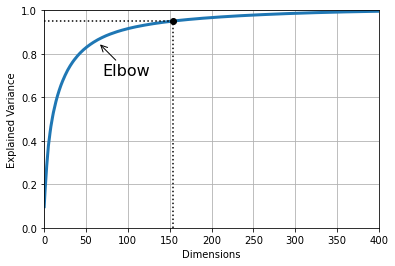

In [16]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()



In [17]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [18]:
pca.n_components_

154

In [19]:
np.sum(pca.explained_variance_ratio_)

0.9504267868707659

## Incremental PCA using scikit-learn or the memmap functionality

In [20]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    X_reduced = inc_pca.transform(X_train)

In [ ]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
    batch_size = m // n_batches
    inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
    inc_pca.fit(X_mm)

## Kernel PCA

In [22]:
from sklearn.model_selection import GridSearchCV 
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import Pipeline

from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)


In [ ]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

In [23]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

NameError: name 'save_fig' is not defined

In [ ]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()



In [ ]:
# Creates a pipeline to do a kernal PCA with 2 components and then tests different hyperparemeters and bases
clf = Pipeline([
            ("kpca", KernelPCA(n_components=2)),
            ("log_reg", LogisticRegression())
])
    param_grid = [{
            "kpca__gamma": np.linspace(0.03, 0.05, 10),
            "kpca__kernel": ["rbf", "sigmoid"]
        }]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

In [ ]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                        fit_inverse_transform=True)
    X_reduced = rbf_pca.fit_transform(X)
    X_preimage = rbf_pca.inverse_transform(X_reduced)

## Local Linear Embeddings (LLE)

In [2]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [3]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

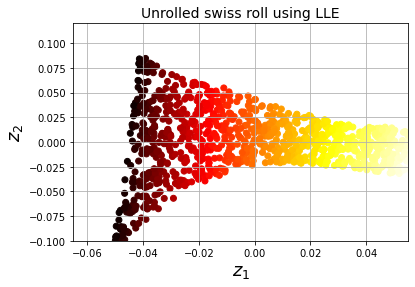

In [5]:
import matplotlib.pyplot as plt
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()
